# Libraries

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score


# metrics

In [81]:
def confusion_matrix(y_true, y_pred):
    tp = np.sum((y_true==1)&(y_pred==1))
    tn = np.sum((y_true==0)&(y_pred==0))
    fp = np.sum((y_true==0)&(y_pred==1))
    fn = np.sum((y_true==1)&(y_pred==0))
    return np.array([[tn, fp], [fn, tp]])

def accuracy_score(y_true, y_pred):
    return np.mean(y_true == y_pred)

def precision_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tp, fp = cm[1,1], cm[0,1]
    return tp / (tp + fp) if (tp + fp) else 0

def recall_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tp, fn = cm[1,1], cm[1,0]
    return tp / (tp + fn) if (tp + fn) else 0

def f1_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tp, fp, fn = cm[1,1], cm[0,1], cm[1,0]
    return 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) else 0

# class MyPCA

In [82]:
class MyPCA:
    def __init__(self, n_components=None):
        self.n_components = n_components

    def fit(self, X):
        # 1) Tâm dữ liệu
        self.mean_ = np.mean(X, axis=0)
        Xc = X - self.mean_
        # 2) Ma trận hiệp phương sai
        n_samples = X.shape[0]
        if X.shape[0] > 10000:
            # phong truong hop du lieu lon
            chunk_size = 1000
            C = np.zeros((X.shape[1], X.shape[1]))
            for i in range(0, n_samples, chunk_size):
                end = min(i + chunk_size, n_samples)
                chunk = Xc[i:end]
                C += np.dot(chunk.T, chunk)
            C /= (n_samples - 1)
        else:
            C = np.dot(Xc.T, Xc) / (n_samples - 1)
        # 3) Tính trị riêng và vector riêng
        eigvals, eigvecs = np.linalg.eigh(C)
        # 4) Sắp xếp giảm dần
        idx = np.argsort(eigvals)[::-1]
        eigvals = eigvals[idx]
        eigvecs = eigvecs[:, idx]
        # 5) Chọn số thành phần
        if self.n_components is not None:
            eigvals = eigvals[:self.n_components]
            eigvecs = eigvecs[:, :self.n_components]
        # 6) Lưu kết quả
        self.components_ = eigvecs.T
        self.explained_variance_ = eigvals
        self.total_var_ = np.sum(np.linalg.eigvalsh(C))  # Total variance
        self.explained_variance_ratio_ = eigvals / self.total_var_
        self.cumulative_explained_variance_ = np.cumsum(self.explained_variance_ratio_)

        return self

    def transform(self, X):
        Xc = X - self.mean_

        return np.dot(Xc, self.components_.T)

    def fit_transform(self, X):
        return self.fit(X).transform(X)

# class KMeans

In [83]:
def kmeans(X, k=2, max_iters=100, tol=1e-6, n_init=10, init_method='kmeans++', random_state=None, early_stopping_iter=5, batch_size=None):
    n_samples, n_features = X.shape
    rng = np.random.default_rng(seed=random_state)
    
    # Add mini-batch optimization
    if batch_size is None:
        batch_size = min(1000, n_samples // 4) if n_samples > 2000 else n_samples
    
    best_inertia = float('inf')
    best_labels = None
    best_centers = None

    for init_attempt in range(n_init):
        # Improved initialization
        if init_method == 'kmeans++':
            centers = np.zeros((k, n_features))
            # Choose first center randomly
            idx = rng.choice(n_samples)
            centers[0] = X[idx].copy()

            # Choose remaining centers with probability proportional to distance squared
            for i in range(1, k):
                # Use matrix operations for faster distance calculation
                diff = X[:, np.newaxis, :] - centers[None, :i, :]
                dist_sq = np.min(np.sum(diff * diff, axis=2), axis=1)

                # Normalize to create probability distribution
                if np.sum(dist_sq) > 0:
                    probs = dist_sq / np.sum(dist_sq)
                    idx = rng.choice(n_samples, p=probs)
                else:
                    idx = rng.choice(n_samples)

                centers[i] = X[idx].copy()
        else:
            # Random initialization
            indices = rng.choice(n_samples, size=k, replace=False)
            centers = X[indices].copy()

        # Optimization loop with early stopping and mini-batch updates
        labels = np.zeros(n_samples, dtype=int)
        prev_inertias = []
        
        # Pre-allocate arrays for efficiency
        distances = np.zeros((batch_size, k))

        for iteration in range(max_iters):
            # Use mini-batches for large datasets
            if n_samples > batch_size:
                batch_indices = rng.choice(n_samples, size=batch_size, replace=False)
                X_batch = X[batch_indices]
                batch_size_actual = len(X_batch)
                
                # Resize distances array if needed
                if distances.shape[0] != batch_size_actual:
                    distances = np.zeros((batch_size_actual, k))
                
                # Calculate distances for batch
                for i in range(k):
                    diff = X_batch - centers[i]
                    distances[:, i] = np.sum(diff * diff, axis=1)
                
                # Update labels for batch
                new_batch_labels = np.argmin(distances, axis=1)
                
                # Update full labels
                old_labels = labels.copy()
                labels[batch_indices] = new_batch_labels
                
                # Check if all labels stayed the same
                if np.array_equal(old_labels, labels):
                    break
            else:
                # Process full dataset for smaller datasets
                for i in range(k):
                    diff = X - centers[i]
                    distances[:n_samples, i] = np.sum(diff * diff, axis=1)
                
                new_labels = np.argmin(distances[:n_samples], axis=1)
                
                if np.array_equal(labels, new_labels):
                    break
                
                labels = new_labels

            # Handle empty clusters with vectorized operations
            for i in range(k):
                mask = labels == i
                if not np.any(mask):
                    # Find the largest cluster
                    cluster_sizes = np.bincount(labels, minlength=k)
                    largest_cluster = np.argmax(cluster_sizes)
                    
                    # Find points in the largest cluster
                    largest_cluster_mask = labels == largest_cluster
                    largest_cluster_points = X[largest_cluster_mask]
                    
                    # Find the point furthest from the center
                    center = centers[largest_cluster]
                    diff = largest_cluster_points - center
                    distances_to_center = np.sum(diff * diff, axis=1)
                    farthest_idx = np.argmax(distances_to_center)
                    
                    # Get original index
                    farthest_point_idx = np.where(largest_cluster_mask)[0][farthest_idx]
                    
                    # Reassign to empty cluster
                    labels[farthest_point_idx] = i

            # Update centers - using vectorized operations
            new_centers = np.zeros_like(centers)
            for i in range(k):
                mask = labels == i
                if np.any(mask):
                    new_centers[i] = np.mean(X[mask], axis=0)
                else:
                    new_centers[i] = centers[i]  # Shouldn't happen with empty cluster handling

            # Calculate inertia more efficiently
            inertia = 0
            for i in range(k):
                mask = labels == i
                if np.any(mask):
                    diff = X[mask] - new_centers[i]
                    inertia += np.sum(diff * diff)

            # Early stopping check using momentum-based convergence detection
            prev_inertias.append(inertia)
            if len(prev_inertias) > early_stopping_iter:
                recent_improvements = np.diff(prev_inertias[-early_stopping_iter:])
                if np.all(np.abs(recent_improvements) < tol * inertia):
                    break

            # Center shift convergence check - faster calculation
            center_shift = np.sum((new_centers - centers)**2)
            centers = new_centers

            if center_shift < tol:
                break

        # Keep best result
        if inertia < best_inertia:
            best_inertia = inertia
            best_labels = labels.copy()
            best_centers = centers.copy()

    return best_labels, best_centers, best_inertia

# preprocess

In [84]:
def preprocessing(X):
    # 1. Identify and handle missing values
    missing_mask = np.isnan(X)
    if np.any(missing_mask):
        # Impute missing values with column medians
        col_medians = np.nanmedian(X, axis=0)
        X_imputed = X.copy()
        for i in range(X.shape[1]):
            mask = missing_mask[:, i]
            if np.any(mask):
                X_imputed[mask, i] = col_medians[i]
        X = X_imputed

    # 2. Handle outliers with winsorization instead of removal
    for col in range(X.shape[1]):
        q1, q3 = np.percentile(X[:, col], [25, 75])
        iqr = q3 - q1
        lower_bound = q1 - 3 * iqr
        upper_bound = q3 + 3 * iqr
        X[:, col] = np.clip(X[:, col], lower_bound, upper_bound)

    # 3. Scale each feature individually using robust scaler
    X_scaled = np.zeros_like(X)
    for col in range(X.shape[1]):
        median = np.median(X[:, col])
        iqr = np.percentile(X[:, col], 75) - np.percentile(X[:, col], 25)
        # Avoid division by zero
        if iqr > 0:
            X_scaled[:, col] = (X[:, col] - median) / iqr
        else:
            # If IQR is zero, use standard scaling
            std = np.std(X[:, col])
            if std > 0:
                X_scaled[:, col] = (X[:, col] - np.mean(X[:, col])) / std
            else:
                # If std is also zero, keep values as zeros
                X_scaled[:, col] = 0

    return X_scaled

# feature selection

In [85]:
# 4. Enhanced feature selection using correlation analysis
def feature_selection(X, threshold=0.7):
    # 1. Calculate variance for each feature
    variances = np.var(X, axis=0)

    # 2. Keep features with variance above a minimum threshold
    min_var_threshold = 0.01 * np.max(variances)
    high_var_mask = variances > min_var_threshold

    # 3. Among high variance features, remove highly correlated ones
    X_high_var = X[:, high_var_mask]

    # Only perform correlation analysis if we have enough features
    if X_high_var.shape[1] > 1:
        # Calculate correlation matrix
        corr_matrix = np.corrcoef(X_high_var.T)

        # Create a mask of features to keep
        to_keep = np.ones(corr_matrix.shape[0], dtype=bool)

        # For each pair of highly correlated features, keep the one with higher variance
        for i in range(corr_matrix.shape[0]):
            if to_keep[i]:
                # Find features correlated with this one
                correlated = np.where((np.abs(corr_matrix[i]) > threshold) & (np.arange(corr_matrix.shape[0]) != i))[0]

                # Get the indices in the original high variance mask
                original_indices = np.where(high_var_mask)[0]

                # For each correlated feature
                for j in correlated:
                    # Keep feature with higher variance, remove the other
                    original_i = original_indices[i]
                    original_j = original_indices[j]

                    if variances[original_i] < variances[original_j]:
                        to_keep[i] = False
                        break
                    else:
                        to_keep[j] = False

        # Update the high variance mask
        original_indices = np.where(high_var_mask)[0]
        selected_indices = original_indices[to_keep]

        # Create final selection mask
        final_mask = np.zeros(X.shape[1], dtype=bool)
        final_mask[selected_indices] = True
    else:
        final_mask = high_var_mask

    return X[:, final_mask], final_mask

# visualize functions

In [86]:
def visualization(X_pca, labels, true_labels=None, title="PCA Visualization"):
    n_components = X_pca.shape[1]

    # If we have at least 3 components, create 3D plot
    if n_components >= 3:
        from mpl_toolkits.mplot3d import Axes3D
        # fig = plt.figure(figsize=(12, 10))
        # ax = fig.add_subplot(111, projection='3d')

        # scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
        #            c=labels, cmap='viridis', marker='o', s=30, alpha=0.7)

        # If true labels are available, add them to another subplot
        if true_labels is not None:
            # Create a side-by-side comparison
            plt.figure(figsize=(18, 8))

            # Plot clustering results
            ax1 = plt.subplot(121, projection='3d')
            ax1.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
                      c=labels, cmap='viridis', marker='o', s=30, alpha=0.7)
            ax1.set_title("Clustering Results")

            # Plot true labels
            ax2 = plt.subplot(122, projection='3d')
            ax2.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
                      c=true_labels, cmap='viridis', marker='o', s=30, alpha=0.7)
            ax2.set_title("True Labels")

    # Otherwise create 2D plot with the first 2 components
    else:
        plt.figure(figsize=(12, 10))
        plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', marker='o', s=30, alpha=0.7)

        # Add cluster centers if we have them
        unique_labels = np.unique(labels)
        for label in unique_labels:
            cluster_points = X_pca[labels == label]
            center = np.mean(cluster_points, axis=0)
            plt.scatter(center[0], center[1], s=200, c='red', marker='X')

        # If we have true labels, create a side-by-side comparison
        if true_labels is not None:
            plt.figure(figsize=(18, 8))

            # Plot clustering results
            plt.subplot(121)
            plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', marker='o', s=30, alpha=0.7)
            plt.title("Clustering Results")

            # Plot true labels
            plt.subplot(122)
            plt.scatter(X_pca[:, 0], X_pca[:, 1], c=true_labels, cmap='viridis', marker='o', s=30, alpha=0.7)
            plt.title("True Labels")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


# clustering pipeline

In [87]:
# 5. clustering evaluation function
def evaluate_clustering(X, labels, true_labels=None):
    metrics_dict = {}

    # Calculate internal validation metrics
    try:
        metrics_dict['silhouette'] = silhouette_score(X, labels)
    except:
        metrics_dict['silhouette'] = -1  # In case of failure

    # Calculate Davies-Bouldin index (lower is better)
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)

    if n_clusters > 1:
        # Calculate cluster centers
        centers = np.zeros((n_clusters, X.shape[1]))
        for i, label in enumerate(unique_labels):
            centers[i] = np.mean(X[labels == label], axis=0)

        # Calculate Davies-Bouldin index
        db_index = 0
        for i in range(n_clusters):
            # Calculate average distance from points to their cluster center
            cluster_i = X[labels == unique_labels[i]]
            if len(cluster_i) > 0:
                diam_i = np.mean(np.linalg.norm(cluster_i - centers[i], axis=1))

                # Find maximum ratio with other clusters
                max_ratio = 0
                for j in range(n_clusters):
                    if i != j:
                        cluster_j = X[labels == unique_labels[j]]
                        if len(cluster_j) > 0:
                            diam_j = np.mean(np.linalg.norm(cluster_j - centers[j], axis=1))
                            dist_ij = np.linalg.norm(centers[i] - centers[j])

                            if dist_ij > 0:  # Avoid division by zero
                                ratio = (diam_i + diam_j) / dist_ij
                                max_ratio = max(max_ratio, ratio)

                db_index += max_ratio

        db_index /= n_clusters
        metrics_dict['davies_bouldin'] = db_index
    else:
        metrics_dict['davies_bouldin'] = -1

    # If we have true labels, calculate external validation metrics
    if true_labels is not None:
        # Handle case where labels might need to be flipped
        accuracy = accuracy_score(true_labels, labels)
        flipped_accuracy = accuracy_score(true_labels, 1 - labels)

        if flipped_accuracy > accuracy:
            labels = 1 - labels
            accuracy = flipped_accuracy

        metrics_dict['accuracy'] = accuracy
        metrics_dict['precision'] = precision_score(true_labels, labels)
        metrics_dict['recall'] = recall_score(true_labels, labels)
        metrics_dict['f1'] = f1_score(true_labels, labels)
        metrics_dict['confusion_matrix'] = confusion_matrix(true_labels, labels)

    return metrics_dict, labels

In [88]:
def clustering_pipeline(X, y_true=None, n_clusters=2):
    print("Starting clustering pipeline...")

    # Step 1: preprocessing
    print("Step 1: Preprocessing...")
    X_preprocessed = preprocessing(X)
    print(f"  Data shape after preprocessing: {X_preprocessed.shape}")

    # Step 2: Enhanced feature selection
    print("Step 2: Enhanced feature selection...")
    X_selected, feature_mask = feature_selection(X_preprocessed, threshold=0.7)
    print(f"  Selected {X_selected.shape[1]} features out of {X_preprocessed.shape[1]}")

    # Step 3: Apply PCA with advanced component selection
    print("Step 3: Applying PCA...")
    pca = MyPCA()
    pca.fit(X_selected)

    # Plot explained variance
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(1, len(pca.explained_variance_ratio_) + 1),
             pca.cumulative_explained_variance_, 'o-')
    plt.axhline(y=0.9, color='r', linestyle='--')
    plt.axhline(y=0.95, color='g', linestyle='--')  
    plt.grid(True)
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA Component Selection')
    plt.show()

    # Find optimal number of components (by cumulative variance)
    # 95%
    n_components = np.where(pca.cumulative_explained_variance_ >= 0.90)[0][0] + 1
    # Ensure we have at least 2 components for visualization
    n_components = max(n_components, 2)
    print(f"  Selected {n_components} PCA components")

    # Apply PCA with selected number of components
    pca = MyPCA(n_components=n_components)
    X_pca = pca.fit_transform(X_selected)

    print(X_pca.shape)

    # Step 4: Try multiple clustering methods and select the best
    print("Step 4: Applying K-means...")

    # Determine batch size based on dataset size
    batch_size = min(1000, X_pca.shape[0] // 4) if X_pca.shape[0] > 2000 else None

    # Determine optimal k
    if y_true is not None and n_clusters is None:
        true_k = len(np.unique(y_true))
        # Test more candidate k values
        candidate_ks = [true_k-1, true_k, true_k+1, true_k+2]
        candidate_ks = [k for k in candidate_ks if k >= 2]
    else:
        candidate_ks = [n_clusters]

    best_score = -float('inf')
    best_k = candidate_ks[0]
    best_labels = None
    best_centers = None
    best_metrics = None

    for k in candidate_ks:
        print(f"  Testing k={k}...")

        # Run k-means with optimal parameters
        labels, centers, inertia = kmeans(
            X_pca, k=k, max_iters=300, tol=1e-6, n_init=20,
            init_method='kmeans++', random_state=42,
            early_stopping_iter=5, batch_size=batch_size
        )
        
        # Evaluate clustering results
        metrics, remapped_labels = evaluate_clustering(X_pca, labels, y_true)
        
        # Choose the best k based on silhouette score
        score = metrics.get('silhouette', -float('inf'))
        
        print(f"  k={k}, Silhouette Score: {score:.4f}")
        if score > best_score:
            best_score = score
            best_k = k
            best_labels = remapped_labels
            best_centers = centers
            best_metrics = metrics

    # Step 5: Visualize results
    print("Step 5: Visualizing results...")
    visualization(X_pca, best_labels, y_true,
                         title=f"PCA Visualization with {n_components} Components")

    # Print final metrics
    print("\nFinal Results:")
    print(f"Number of PCA components: {n_components}")
    for metric, value in best_metrics.items():
        if metric != 'confusion_matrix':
            print(f"{metric}: {value:.4f}")

    if y_true is not None:
        print("Confusion Matrix:")
        print(best_metrics['confusion_matrix'])

    return best_labels, best_metrics, n_components, X_pca, feature_mask

# Chuẩn bị dữ liệu

In [89]:
df = pd.read_csv('../data/ABIDE2.csv')

In [90]:
print(f"Kích thước dataset: {df.shape}")
print(f"Số lượng mỗi nhóm:")
print(df['group'].value_counts())

Kích thước dataset: (1004, 1445)
Số lượng mỗi nhóm:
group
Normal    541
Cancer    463
Name: count, dtype: int64


In [91]:
# Assume these columns are not used for clustering
X = df.drop(columns=['site', 'subject', 'group']).values
y = df['group'].values

# Convert labels to numeric (0: Normal, 1: Cancer)
y_numeric = np.where(y == 'Cancer', 1, 0)

# Tìm các tham số tối ưu

Starting clustering pipeline...
Step 1: Preprocessing...
  Data shape after preprocessing: (1004, 1442)
Step 2: Enhanced feature selection...
  Selected 609 features out of 1442
Step 3: Applying PCA...


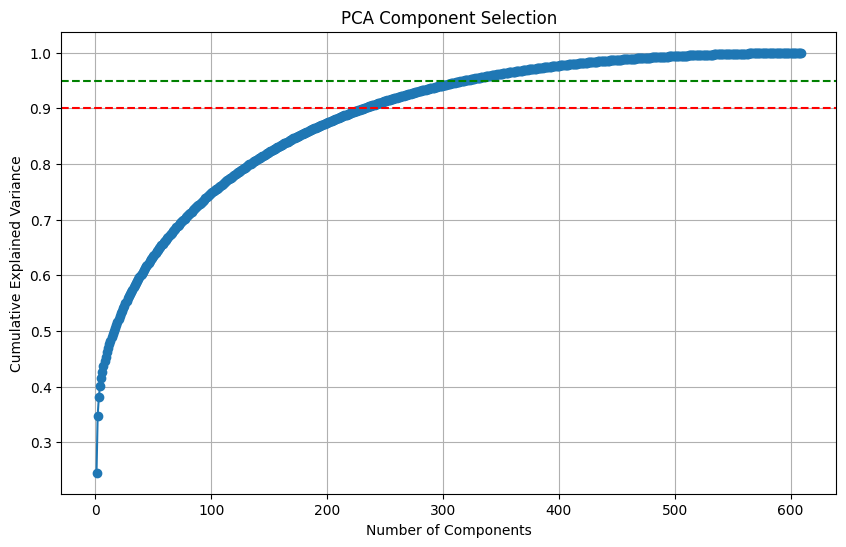

  Selected 232 PCA components
(1004, 232)
Step 4: Applying K-means...
  Testing k=2...
  k=2, Silhouette Score: 0.1805
Step 5: Visualizing results...


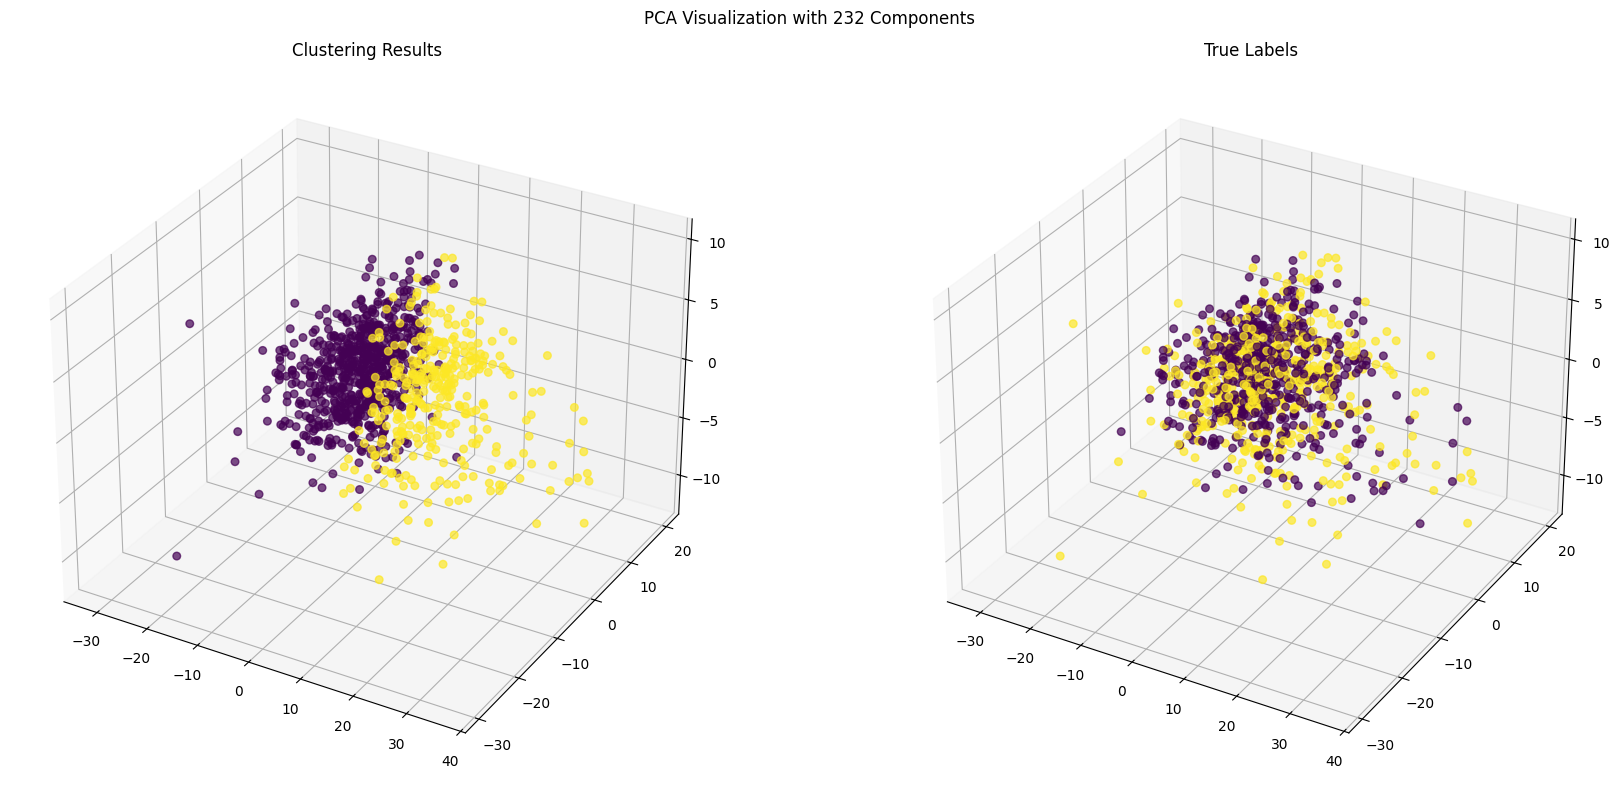


Final Results:
Number of PCA components: 232
silhouette: 0.1805
davies_bouldin: 1.9579
accuracy: 0.5408
precision: 0.5030
recall: 0.3585
f1: 0.4187
Confusion Matrix:
[[377 164]
 [297 166]]


In [92]:
# Run the improved clustering pipeline
final_labels, metrics, n_components, X_pca, feature_mask = clustering_pipeline(X, y_numeric)

# Kết quả

In [93]:
# Print final results
print("\nFinal Results:")
print(f"Number of PCA components: {n_components}")
print(f"Accuracy: {metrics['accuracy']:.4f}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall: {metrics['recall']:.4f}")
print(f"F1 score: {metrics['f1']:.4f}")
print(f"Silhouette score: {metrics['silhouette']:.4f}")


Final Results:
Number of PCA components: 232
Accuracy: 0.5408
Precision: 0.5030
Recall: 0.3585
F1 score: 0.4187
Silhouette score: 0.1805
